In [49]:
from plane_cylinder_projections import *
from visualizations import plot_ground_truth_3d, validation_of_3d_tangent_estimation
from constants import *
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


| Plane and normal $\vec{p}$ | Plane normal vector dip $\delta$ , azimuth $\alpha$ |
| :--: |  :--: | 
|  ![](report/plane_normal_definition.png) | ![](report/normal_definition.png) |

- If $\delta=0$, horizontal slice ($alpha$ is not informative by the way), we'll get a line in the images

In [50]:
# First, let's define some groundtruth planes (dip, azimut)
plane_angle = torch.tensor(
    [
        [torch.pi/4, torch.pi/4, 0.],
        [0.8*torch.pi/2., torch.pi/4, -1.],
        [0.9*torch.pi/2., torch.pi/3, -0.5],
        [0.1, torch.pi/2, -1.2],
    ]
)

In [51]:
# Let's sample the azimuth coordinates and compute the altitude of the planes
n_points = 360
azimuth_coordinates_phi = torch.linspace(0, 2*torch.pi, 360).unsqueeze(0)
azimuth_coordinates_phi = azimuth_coordinates_phi.repeat(plane_angle.shape[0], 1)
altitude_z = intersect_plane_with_cyliner(azimuth_coordinates_phi, plane_angle)
p3D_gt = angle_to_3d_vector(azimuth_coordinates_phi, altitude_z=altitude_z) # [N, L, 3]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


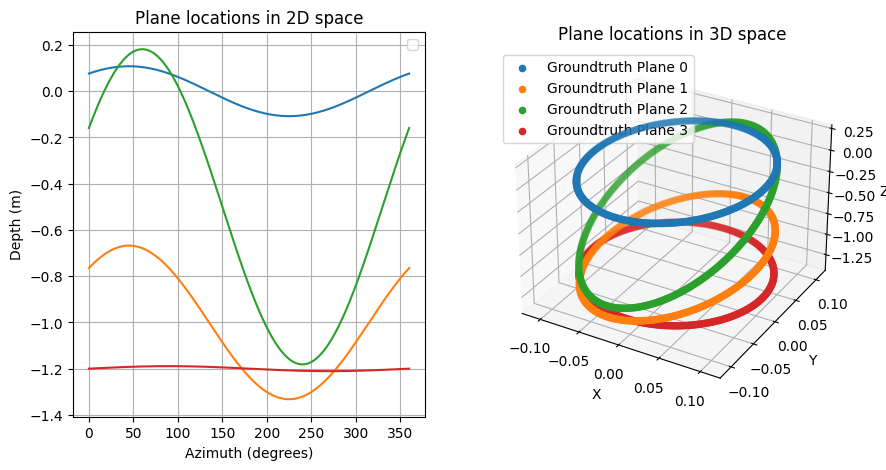

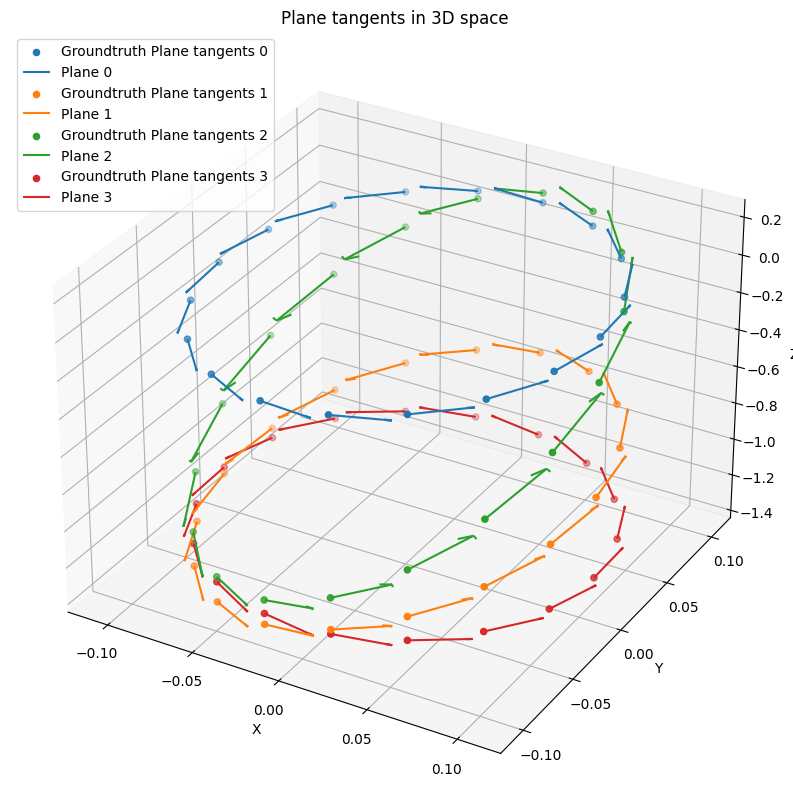

In [52]:
plot_ground_truth_3d(
    azimuth_coordinates_phi,
    altitude_z,
    p3D_gt
)

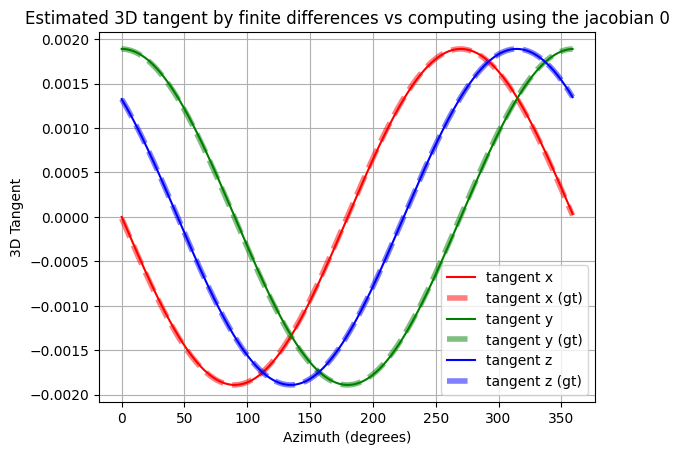

In [55]:
validation_of_3d_tangent_estimation(azimuth_coordinates_phi, altitude_z, p3D_gt=p3D_gt, batches_index=[0])

In [ ]:
# splat
w = 365
h = 600
plt.figure(figsize=(10, 10))
img = np.zeros((h, w), dtype=np.float32)
img+= np.random.normal(0, 0.02, img.shape)
for batch_idx in range(altitude_z.shape[0]):
    for idx in range(altitude_z.shape[1]):
        z = altitude_z[batch_idx, idx]
        azi_deg = azimuth_coordinates_phi[batch_idx, idx]
        azi_deg = np.rad2deg(azi_deg)
        row = int(-z/DEPTH_STEP)
        if row < 0 or row >= h:
            continue

        col = int(azi_deg)
        if col < 0 or col >= w:
            continue
        # img[row-1:row+1, col-1:col+1] = 1.
        img[row, col] = 1.
img = filters.gaussian(img, sigma=2)
plt.title('Simulated borehole image')
plt.imshow(
    img,
    # cmap='gray'
    cmap='hot'
)
plt.show()

In [ ]:

img_grad =filters.sobel(img)
# plt.imshow(img_grad, cmap='gray')
# plt.show()
plt.hist(img_grad.flatten(), bins=20)
plt.title('Histogram of image gradient magnitude')
plt.grid()
plt.show()

In [ ]:
img_grad_v  = filters.sobel_h(img) # find the horizontal edges  =vertical gradient
img_grad_h  = filters.sobel_v(img) # find the vertical edges = horizontal gradient
high_amplitude = (img_grad > 0.02)
img_grad_h[~high_amplitude] = np.NaN
img_grad_v[~high_amplitude] = np.NaN
img_grad_h*= -np.sign(img_grad_v)
img_grad_v*= -np.sign(img_grad_v)
# PREPARE GRADIENTS

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap="hot")
plt.quiver(img_grad_h, img_grad_v, color="green")
plt.show()

In [ ]:
coords = np.array(np.where(high_amplitude)).T
gradients_image_scales = np.array([img_grad_h[high_amplitude], img_grad_v[high_amplitude]]).T
gradients_unscaled = gradients_image_scales / np.linalg.norm(gradients_image_scales, axis=1)[:, None]
tangents_unscaled = np.array([-img_grad_v[high_amplitude], img_grad_h[high_amplitude]]).T
tangents_unscaled = tangents_unscaled / np.linalg.norm(tangents_unscaled, axis=1)[:, None]
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
for coord_idx in range(coords.shape[0]):
    if coord_idx % 20 != 0:
        continue
    plt.arrow(
        coords[coord_idx, 1], coords[coord_idx, 0], 
        20.*gradients_unscaled[coord_idx, 0],
        20.*gradients_unscaled[coord_idx, 1], 
        head_width=2., head_length=3.,
        fc='b',
        ec='g'
    )
    plt.arrow(
        coords[coord_idx, 1], coords[coord_idx, 0], 
        20.*tangents_unscaled[coord_idx, 0],
        20.*tangents_unscaled[coord_idx, 1], 
        head_width=2., head_length=3.,
        fc='b',
        ec='r'
    )
plt.title('Tangents to the projected 3D points')
plt.show()

In [ ]:
# Compute the correctly scaled tangent vectors (in SI units, angles in radians, altitudes in meters)
tan_vec_2d = get_tangent_vec_from_gradients(img_grad_h[high_amplitude], img_grad_v[high_amplitude], normalize=False)

In [ ]:
# Compute the 3D tangent vectors (and normalize)
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)

azi_list = torch.deg2rad(img_coords[:, 1]).unsqueeze(0)
alt_list = -img_coords[:, 0]*DEPTH_STEP
tangent = np.array([
    -gradients_unscaled[:, 1], # y 
    gradients_unscaled[:, 0],
]).T
tangent.shape
tangents_3d = []
for idx in range(azi_list.shape[1]):
    azi = azi_list[0, idx]
    alt = alt_list[idx]
    delta_azi = tan_vec_2d[idx, 0]
    delta_alt = tan_vec_2d[idx, 1]
    tan3d = image_vector_to_3d_plane_tangent(azi, alt, delta_azi, delta_alt)
    tan3d = tan3d / tan3d.norm() # normalize the 3D tangent
    tangents_3d.append(tan3d)
tangents_3d = torch.stack(tangents_3d, dim=0).unsqueeze(0)

In [ ]:
def get_cross_products(tangents_3d):
    random_pairs_indexes = torch.randint(0, tangents_3d.shape[-2], (100, 2))
    random_pairs =  tangents_3d[:, random_pairs_indexes,:]
    cross_product = torch.cross(random_pairs[:, :, 0, :], random_pairs[:, :, 1, :], dim=-1)
    cross_product_norm = cross_product.norm(dim=-1, keepdim=True)

    cross_product = cross_product/cross_product_norm
    cross_product.shape
    return cross_product, cross_product_norm
cross_product_estimated, cross_product_norm_estim = get_cross_products(tangents_3d)
# cross_product.norm(dim=-1)

In [ ]:
tangents_3d.shape


In [ ]:
def plot_cross_products(cross_product):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    for batch_index in range(cross_product.shape[0]):
        tangent3d_x, tangent3d_y, tangent3d_z = cross_product[batch_index, :, 0], cross_product[batch_index, :, 1], cross_product[batch_index, :, 2]
        origin = np.zeros_like(tangent3d_x)
        # ax.quiver(origin, origin, origin, tangent3d_x, tangent3d_y, tangent3d_z,
        #           arrow_length_ratio=0.2,
        #           label=f"Plane {batch_index}")
        ax.scatter(tangent3d_x, tangent3d_y, tangent3d_z, label=f"Plane {batch_index}")
        # size=cross_product_norm[batch_index, :, 0].numpy()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()
    ax.set_title('Plane tangents in 3D space')
    plt.show()

In [ ]:
estimated_grad_list.unsqueeze(0).shape

In [ ]:
# gt_grad_tensor = torch.stack(estimated_grad_list)

In [ ]:
# plot_cross_products(cross_product_estimated)
cross_product_gt, cross_product_norm_gt = get_cross_products(estimated_grad_list.unsqueeze(0))
cross_product_gt.shape
plot_cross_products(cross_product_gt)


In [ ]:
tangent3d = (p3D_gt[..., 1:, :] - p3D_gt[..., :-1, :])
tangent3d = tangent3d / tangent3d.norm(dim=-1, keepdim=True)
plt.figure(figsize=(10, 10))
for dim_idx, dim_name, dim_color  in zip(range(3), "xyz", "rgb"): 
    for batch_idx in range(azimuth_coordinates_phi.shape[0]):
        plt.plot(
            torch.rad2deg(azimuth_coordinates_phi[batch_idx, :-1]),
            tangent3d[batch_idx,  :, dim_idx],
            "-",
            color=dim_color,
            linewidth=4, alpha=1.,
            label=f"GT tangent {dim_name} BATCH {batch_idx}"
        )
    for batch_idx in range(azi_list.shape[0]):
        plt.plot(torch.rad2deg(azi_list[batch_idx]), -tangents_3d[batch_idx, :, dim_idx], "."+dim_color, label=f"tangent {dim_name}", alpha=0.1)
plt.xlabel("Azimuth (degrees)")
plt.ylabel("3D Tangent")
plt.legend()
plt.grid()
plt.title("Estimated 3D tangents vs Groundtruth 3D tangents")
plt.show()

In [ ]:
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)